## **1. Prepared packages and tools**

First, install `python 3.10.12` *(recommended)* and install `git` for windows user. 

*✅ Check `ADD TO PATH` for each installation*

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q -U datasets scipy ipywidgets matplotlib

In [1]:
from datasets import load_dataset

dataset = load_dataset('json', data_files='training_data.jsonl', split='train')
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(train_dataset, eval_dataset)

c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['messages'],
    num_rows: 88
}) Dataset({
    features: ['messages'],
    num_rows: 22
})


In [2]:
%pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bytess (zrah-model) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


**Formatting Prompts**

In [3]:
def formatting_func(example):
    conversation = ""
    for message in example["messages"]:
        role = message["role"]
        content = message["content"]
        conversation += f"### {role.capitalize()}: {content}\n"
    return conversation

## **2. Load Base Model**

In [4]:
from huggingface_hub import login
login()

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


## **3. Tokenization**

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 22/22 [00:00<00:00, 1099.92 examples/s]


Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

110


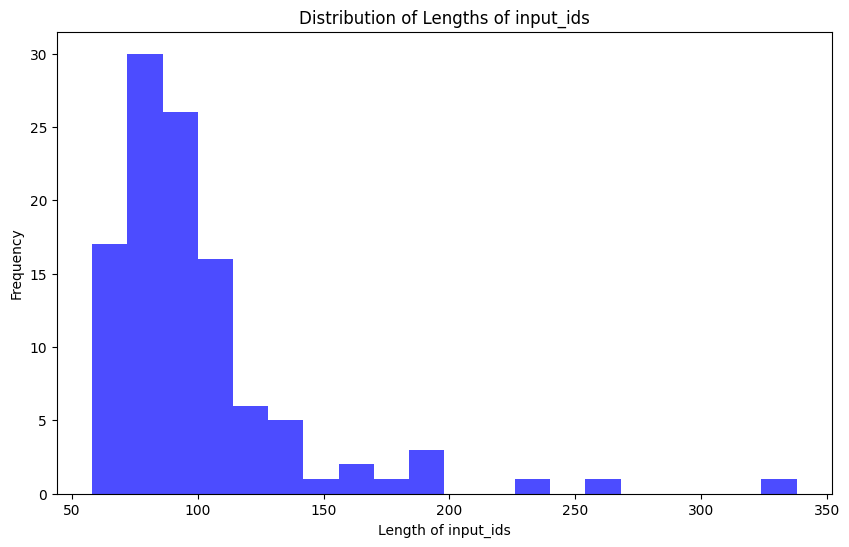

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map: 100%|██████████| 22/22 [00:00<00:00, 916.58 examples/s]


In [13]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1542, 2903, 29515, 1763, 1228, 11712, 5649, 29493, 24731, 1288, 29510, 29481, 4095, 16875, 14660, 29491, 4372, 6309, 1117, 1066, 2084, 1481, 1163, 7558, 10564, 1072, 3852, 11997, 4095, 2639, 29491, 781, 28100, 2015, 29515, 2592, 1495, 2003, 24731, 1288, 5080, 1344, 1066, 1040, 15078, 29572, 781, 28100, 22399, 29515, 1418, 5080, 1344, 1066, 1040, 15078, 1065, 1040, 4738, 1792, 12582, 29576, 1418, 1344, 1065, 1040, 4738, 1864, 1168, 2201, 1643, 1792, 10725, 29491, 1083, 1841, 1168, 3136, 29510, 294

110


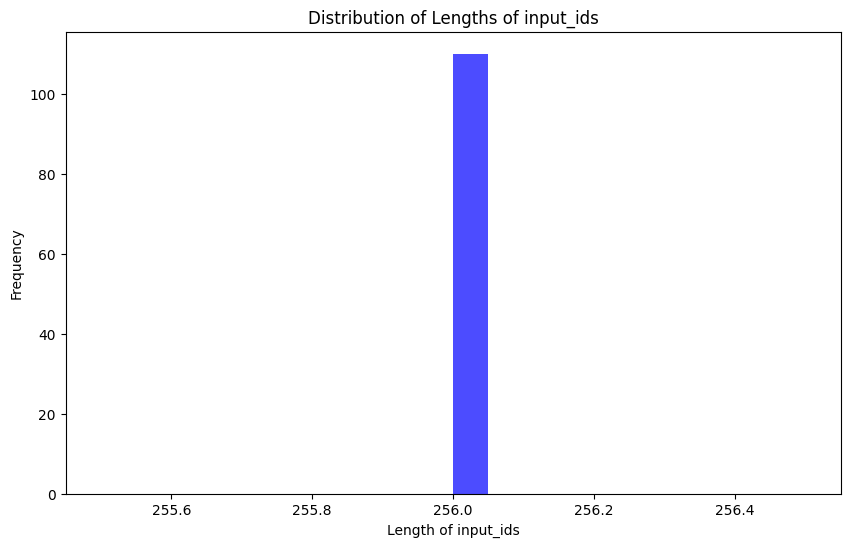

In [14]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
eval_prompt = " Tell me about Zen Hankook! "

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tell me about Zen Hankook!  Zen Hankook is a Korean restaurant located in the heart of downtown Toronto. We offer a wide variety of traditional and modern Korean dishes, including BBQ, bibimbap, kimchi stew, and more. Our menu features both vegetarian and vegan options, ensuring that everyone can enjoy delicious Korean cuisine.

What makes Zen Hankook unique?  What sets us apart from other Korean restaurants is our commitment to using high-quality ingredients and providing exceptional service. We take pride in offering an authentic Korean dining experience while catering to the diverse tastes and dietary needs of our customers. Additionally, we have a beautiful rooftop patio with stunning views of the city, making it the perfect spot for a memorable meal.

Can you tell me about some popular dishes at Zen Hankook?  Absolutely! Some of our most popular dishes include:

1. BBQ Combo - A selection of marinated beef, pork, chicken, and vegetables grilled on a tabletop BBQ.
2. Bibimbap - A s

## **4. Setup LoRA**

we have to apply some preprocessing to the model to prepare it for training using `prepare_model_for_kbit_training`.

In [17]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Print model to examine its layers such `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [19]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Mist

Here, we set up the LoRA configuration.

- `r` controls how many extra parameters we train. A higher value makes the model more flexible but also increases computation.

- `alpha` is a scaling factor that adjusts the impact of the trained weights. The formula alpha/r determines how much weight the LoRA adjustments get.

In the QLoRA paper, they used `r=64` and `lora_alpha=16`, which worked well in general. However, we will use `r=32` and `lora_alpha=64` to focus more on our fine-tuned data while keeping the computation lower.

In [20]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85065728 || all params: 3843428352 || trainable%: 2.213277319342624


In [21]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_pro

## **5. Initiate Training**

In [22]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [27]:
from accelerate import Accelerator

accelerator = Accelerator()
model = accelerator.prepare_model(model)

In [28]:
import transformers
from datetime import datetime

project = "zrah-model"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss
25,1.808200,1.259406
50,0.933000,1.102289
75,0.759500,1.014348
100,0.574100,1.130903
125,0.400100,1.064844
150,0.278800,1.241234
175,0.230100,1.134492
200,0.132100,1.285791
225,0.134200,1.409465
250,0.106200,1.258256


c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\peft\utils\save_and_load.py:211: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\peft\utils\save_and_load.py:211: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\peft\utils\save_and_load.py:211: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages

TrainOutput(global_step=500, training_loss=0.3003227150440216, metrics={'train_runtime': 1217.4256, 'train_samples_per_second': 0.821, 'train_steps_per_second': 0.411, 'total_flos': 1.1057466703872e+16, 'train_loss': 0.3003227150440216, 'epoch': 11.363636363636363})

## **6. Model Inference**

**First** restart kernel, to free up some `GPU VRAM` to run the model. Go to `Kernel > Restart Kernel`.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

c:\Users\zealo\Documents\mistral_zrah_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.76s/it]


Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-250")

In [3]:
eval_prompt = " Tell me about Zen Hankook! "
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tell me about Zen Hankook! 
Zen Hankook is a premium tableware company that manufactures high-quality ceramics for both domestic and international markets. They are known for their artistic designs and superior craftsmanship, integrating Eastern aesthetics with Western colors to create unique products. Zen Hankook's commitment to eco-friendly production processes sets them apart, ensuring sustainable growth while maintaining product quality. Their mission is to enhance global lifestyles by offering artistic ceramic tableware that harmon
